In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma

def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables
    a = 0.0 # axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 100
    Erroriterations =0.00001 # error limit for iteration rpocess, in absolute value of induction
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
      
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube 
        CT = load3Daxial/(0.5*Area*Uinf**2)
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction(CT)
        
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.75*a+0.25*anew # for improving convergence, weigh current and previous iteration of axial induction

        # calculate aximuthal induction
        aline = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline =aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break

    return [a , aline, r_R, fnorm , ftan, gamma]

In [4]:
# import polar
airfoil = 'DU_polar.txt'

data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]


In [47]:
# define the blade geometry
delta_r_R = .01
r_R = np.arange(0.2, 1+delta_r_R/2, delta_r_R)

# blade shape
pitch = 2 # degrees
chord_distribution = 3*(1-r_R)+1 # meters
twist_distribution = -14*(1-r_R)+pitch # degrees

# define flow conditions
Uinf = 1 # unperturbed wind speed in m/s
TSR = 10 # tip speed ratio
Radius = 50
Omega = Uinf*TSR/Radius
NBlades = 3

TipLocation_R =  1
RootLocation_R =  0.2


# solve BEM model


results =np.zeros([len(r_R)-1,6])

for i in range(len(r_R)-1):
    chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
    twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)

    results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )




In [48]:
areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2
dr = (r_R[1:]-r_R[:-1])*Radius
CT = np.sum(dr*results[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
CP = np.sum(dr*results[:,4]*results[:,2]*NBlades*Radius*Omega/(0.5*Uinf**3*np.pi*Radius**2))

print("CT = {}".format(CT))
print("CP = {}".format(CP))

CT = 0.764441996218922
CP = 0.4580635216836007


# Finds pitch angles to CT values

we are at 0 iterations
we are at 20 iterations
we are at 40 iterations
we are at 60 iterations
we are at 80 iterations
we are at 100 iterations
we are at 120 iterations
we are at 140 iterations
we are at 160 iterations
we are at 180 iterations


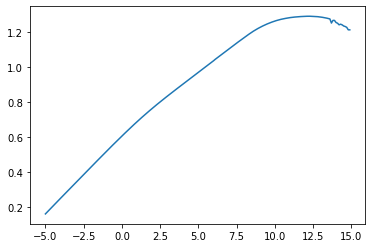

In [7]:
# solve BEM model
pitch_range = np.arange(-5, 15, 0.1)
pitch_ct = np.zeros([len(pitch_range),3])

for j, pitch in enumerate(pitch_range):
    results =np.zeros([len(r_R)-1,6])
    twist_distribution = 14*(1-r_R)+pitch # degrees
    for i in range(len(r_R)-1):
        chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
        twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)

        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )
        
    areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2
    dr = (r_R[1:]-r_R[:-1])*Radius
    CT = np.sum(dr*results[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
    CP = np.sum(dr*results[:,4]*results[:,2]*NBlades*Radius*Omega/(0.5*Uinf**3*np.pi*Radius**2))
    pitch_ct[j,:] = (pitch, CT, CP)
    if j%20==0:
        print('we are at {} iterations'.format(j))
    

plt.figure()
plt.plot(pitch_ct[:,0], pitch_ct[:,1])

In [58]:
# TO DO: find pitch angles to its respective CT value
def find_nearest_pitch(array, CT):
    return round(np.interp(CT, array[:,1], array[:,0]), 3)
 

In [57]:
find_nearest_pitch(pitch_ct, 0.5)

-1.2136434725101337

-0.06243347684254697

# Pitt-Peters model

# Oye dynamic inflow

# Larsen-Madsen model